<h1>Early disease prediction and Bio medical Sustainability</h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_breast_cancer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import skfuzzy as fuzz
from skfuzzy import control as ctrl

<h3>Loading Datasets</h3>

In [2]:
#cancer
cancer_df = pd.read_csv(r"C:\Users\diund\OneDrive\PYTHO\ntcc\data\data.csv")
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
cancer_df['diagnosis'] = cancer_df['diagnosis'].map({'M': 1, 'B': 0})

In [4]:
cancer_df = cancer_df.drop(columns=["id", "Unnamed: 32"], errors='ignore')

<h3>Data preprocessing</h3>

In [5]:
# Preprocessing Function
def preprocess_data(df, target):
    df = df.dropna()
    X = df.drop(columns=[target])
    y = df[target]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
def preprocess_data(df, target):
    df = df.copy()
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found.")

    X = df.drop(columns=[target])
    y = df[target]

    if X.isnull().sum().sum() > 0:
        X = X.fillna(X.median(numeric_only=True))  # Handle missing data safely

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Preprocess all dataset
X_train_c, X_test_c, y_train_c, y_test_c = preprocess_data(cancer_df, "diagnosis")

In [8]:
# confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

accuracies = {"Dataset": [], "Model": [], "Accuracy": []}
nn_models = {}

In [9]:
# Neural Network Training
def train_nn_model(X_train, y_train, X_test, y_test, dataset_name):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, validation_split=0.1)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f"\n{dataset_name} Neural Network Report:")
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    plot_conf_matrix(y_test, y_pred, f"{dataset_name} - NN")
    accuracies["Dataset"].append(dataset_name)
    accuracies["Model"].append("Neural Network")
    accuracies["Accuracy"].append(acc)
    nn_models[dataset_name] = model

In [10]:
# Random Forest Training
def train_rf_model(X_train, y_train, X_test, y_test, dataset_name):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{dataset_name} Random Forest Report:")
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    plot_conf_matrix(y_test, y_pred, f"{dataset_name} - RF")
    accuracies["Dataset"].append(dataset_name)
    accuracies["Model"].append("Random Forest")
    accuracies["Accuracy"].append(acc)
    

<h3>Transformer</h3>

In [11]:
# Simple Transformer
def train_transformer_model(X_train, y_train, X_test, y_test, dataset_name):
    class SimpleTransformer(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.linear = nn.Linear(input_dim, 64)
            encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, batch_first=True)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
            self.output = nn.Linear(64, 1)

        def forward(self, x):
            x = self.linear(x)
            x = self.transformer(x.unsqueeze(1)).squeeze(1)
            return torch.sigmoid(self.output(x)).squeeze(-1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = SimpleTransformer(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(20):
        for xb, yb in loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy() > 0.5
    print(f"\n{dataset_name} Transformer Report:")
    print(classification_report(y_test, preds))
    acc = accuracy_score(y_test, preds)
    print("Accuracy:", acc)
    plot_conf_matrix(y_test, preds, f"{dataset_name} - Transformer")
    accuracies["Dataset"].append(dataset_name)
    accuracies["Model"].append("Transformer")
    accuracies["Accuracy"].append(acc)



--- BREAST CANCER ---


c:\Users\diund\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Breast Cancer Neural Network Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy: 0.9824561403508771


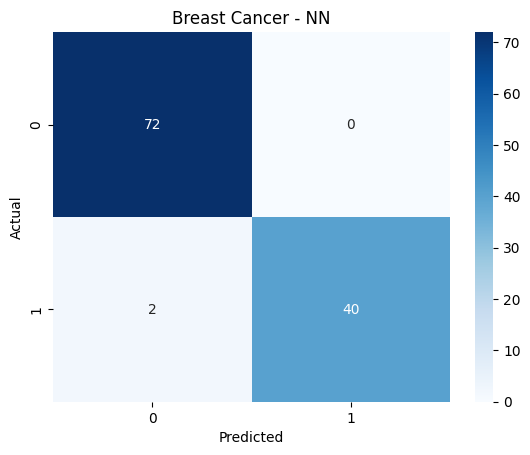


Breast Cancer Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158


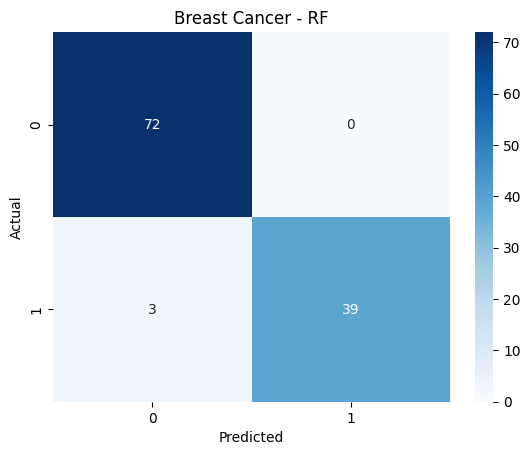


Breast Cancer Transformer Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158


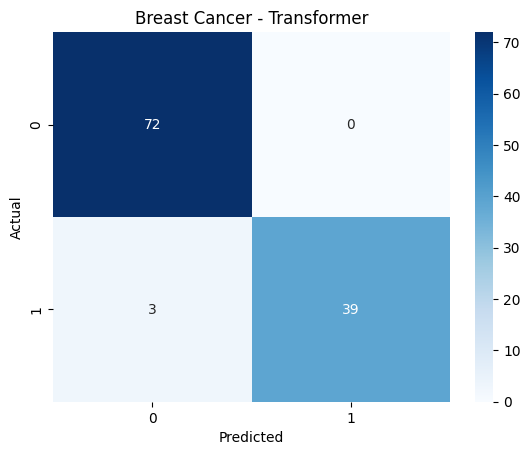

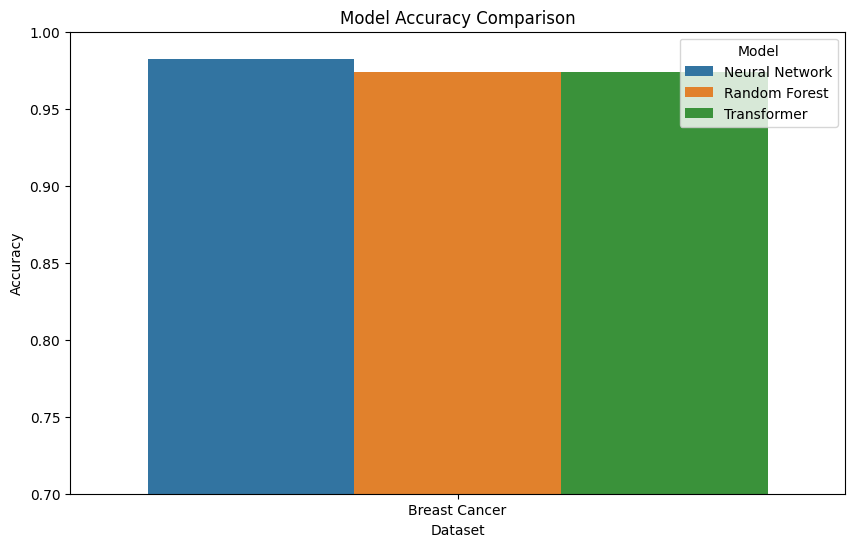

In [12]:
# Train models

print("\n--- BREAST CANCER ---")
train_nn_model(X_train_c, y_train_c, X_test_c, y_test_c, "Breast Cancer")
train_rf_model(X_train_c, y_train_c, X_test_c, y_test_c, "Breast Cancer")
train_transformer_model(X_train_c, y_train_c, X_test_c, y_test_c, "Breast Cancer")

# Accuracy Summary
acc_df = pd.DataFrame(accuracies)
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=acc_df)
plt.title("Model Accuracy Comparison")
plt.ylim(0.7, 1.0)
plt.show()



🌟 Fuzzy Logic Risk Level (0 low - 1 high): 0.54


c:\Users\diund\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


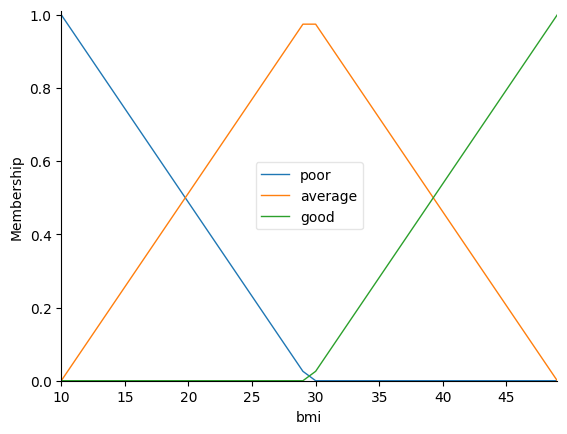

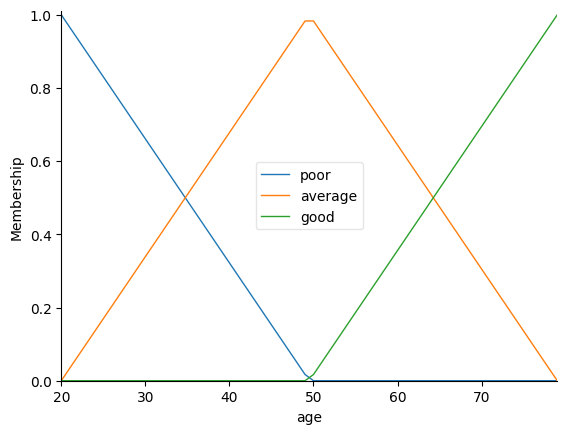

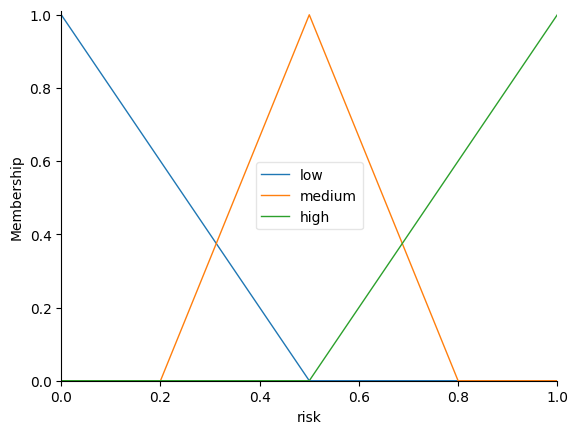

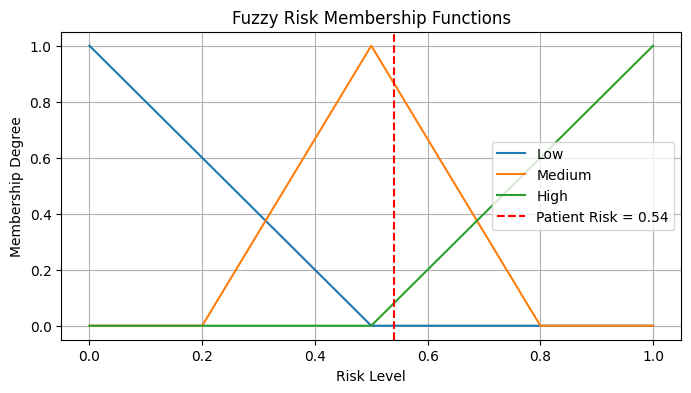

In [19]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# ------------------------------
# Fuzzy variables
# ------------------------------
bmi = ctrl.Antecedent(np.arange(10, 50, 1), 'bmi')
age = ctrl.Antecedent(np.arange(20, 80, 1), 'age')
risk = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'risk')

bmi.automf(3)   # poor, average, good
age.automf(3)

risk['low'] = fuzz.trimf(risk.universe, [0, 0, 0.5])
risk['medium'] = fuzz.trimf(risk.universe, [0.2, 0.5, 0.8])
risk['high'] = fuzz.trimf(risk.universe, [0.5, 1, 1])

# Rules
rule1 = ctrl.Rule(bmi['poor'] | age['poor'], risk['high'])
rule2 = ctrl.Rule(bmi['average'] & age['average'], risk['medium'])
rule3 = ctrl.Rule(bmi['good'] & age['good'], risk['low'])

risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

# ------------------------------
# Example patient input
# ------------------------------
risk_sim.input['bmi'] = 28
risk_sim.input['age'] = 45
risk_sim.compute()

risk_value = round(risk_sim.output['risk'], 2)
print("\n🌟 Fuzzy Logic Risk Level (0 low - 1 high):", risk_value)

# ------------------------------
# Plot membership functions
# ------------------------------

# Plot input variables
bmi.view()
age.view()

# Plot output variable (risk)
risk.view()

# ------------------------------
# Plot the output with patient value
# ------------------------------
plt.figure(figsize=(8, 4))
x_risk = np.arange(0, 1.1, 0.1)
plt.plot(x_risk, fuzz.trimf(x_risk, [0, 0, 0.5]), label='Low')
plt.plot(x_risk, fuzz.trimf(x_risk, [0.2, 0.5, 0.8]), label='Medium')
plt.plot(x_risk, fuzz.trimf(x_risk, [0.5, 1, 1]), label='High')

# Mark the patient’s risk level
plt.axvline(risk_value, color='red', linestyle='--', label=f'Patient Risk = {risk_value}')
plt.title('Fuzzy Risk Membership Functions')
plt.xlabel('Risk Level')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()


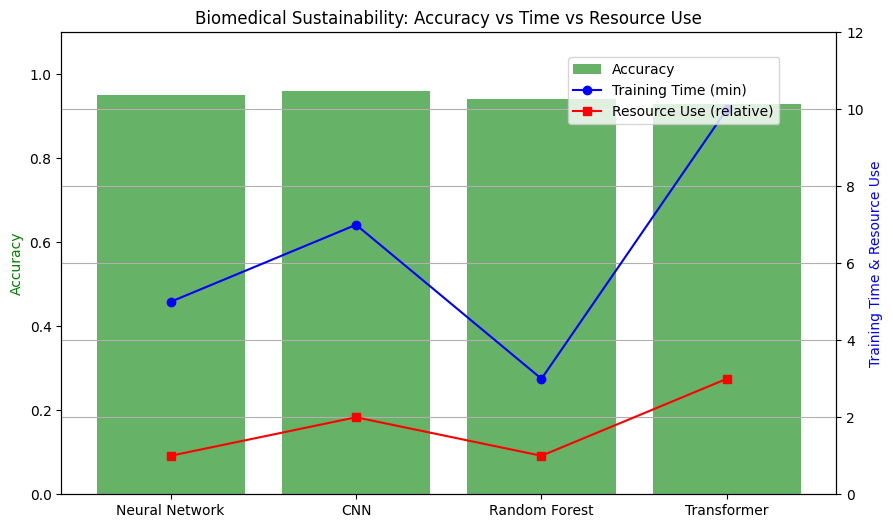

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your real results if you have them)
models = ["Neural Network", "CNN", "Random Forest", "Transformer"]
accuracy = [0.95, 0.96, 0.94, 0.93]  # hypothetical
training_time = [5, 7, 3, 10]         # minutes
resource_use = [1, 2, 1, 3]           # relative scale: 1=low, 3=high

x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy bars
ax1.bar(x, accuracy, color='green', alpha=0.6, label='Accuracy')
ax1.set_ylabel('Accuracy', color='green')
ax1.set_ylim(0, 1.1)
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Training Time & Resource Use (lines)
ax2 = ax1.twinx()
ax2.plot(x, training_time, color='blue', marker='o', label='Training Time (min)')
ax2.plot(x, resource_use, color='red', marker='s', label='Resource Use (relative)')
ax2.set_ylabel('Training Time & Resource Use', color='blue')
ax2.set_ylim(0, max(training_time + resource_use) + 2)

# Title & Legends
plt.title('Biomedical Sustainability: Accuracy vs Time vs Resource Use')
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
plt.grid(True)
plt.show()


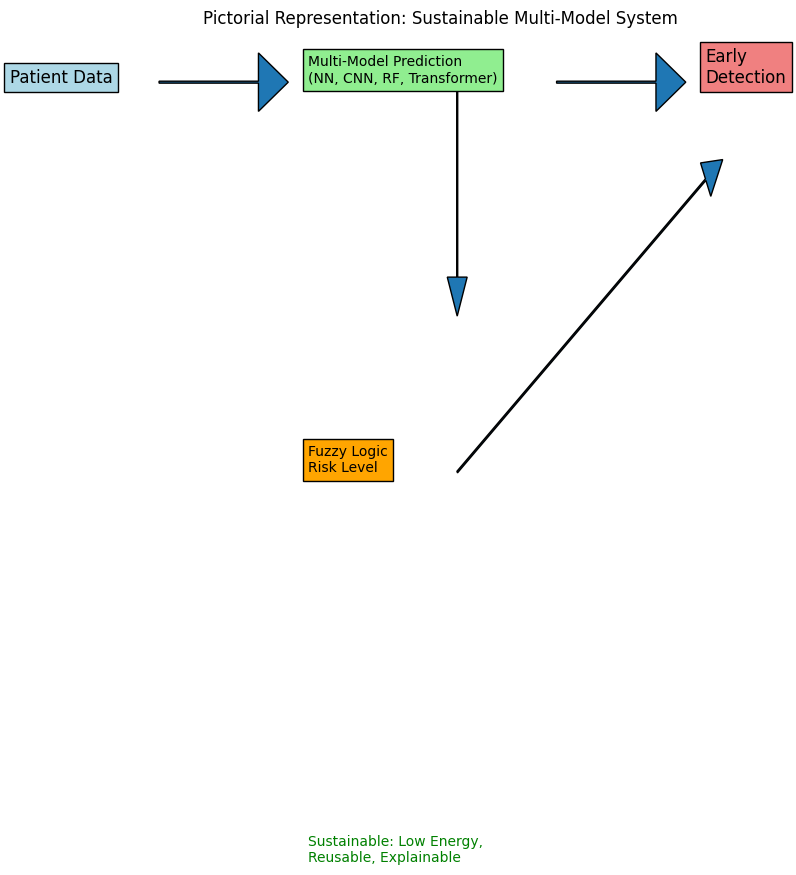

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Draw blocks
ax.text(0.1, 0.7, "Patient Data", bbox=dict(facecolor='lightblue'), fontsize=12)
ax.arrow(0.25, 0.7, 0.1, 0, head_width=0.03, head_length=0.03)

ax.text(0.4, 0.7, "Multi-Model Prediction\n(NN, CNN, RF, Transformer)", bbox=dict(facecolor='lightgreen'), fontsize=10)
ax.arrow(0.65, 0.7, 0.1, 0, head_width=0.03, head_length=0.03)

ax.text(0.8, 0.7, "Early\nDetection", bbox=dict(facecolor='lightcoral'), fontsize=12)

# Fuzzy Logic Risk Path
ax.text(0.4, 0.5, "Fuzzy Logic\nRisk Level", bbox=dict(facecolor='orange'), fontsize=10)
ax.arrow(0.55, 0.7, 0, -0.1, head_width=0.02, head_length=0.02)
ax.arrow(0.55, 0.5, 0.25, 0.15, head_width=0.02, head_length=0.02)

# Sustainability label
ax.text(0.4, 0.3, "Sustainable: Low Energy,\nReusable, Explainable", fontsize=10, color='green')

ax.axis('off')
plt.title("Pictorial Representation: Sustainable Multi-Model System")
plt.show()
